# Dati regionali generali

In [1]:
%load_ext autoreload
%autoreload 2

import json
import os
from collections import OrderedDict
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
%matplotlib notebook
import pandas as pd

# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

from utility.metrics import rt_rki
from utility.utility import get_colore

# Aggiornare con il proprio path locale
# prociv_repo_dir = "/media/michele/DATA-2/Covid/prociv-covid"
prociv_repo_dir = "/home/michele/Covid/prociv-covid"

Lettura dati Istat sulla popolazione

In [2]:
popolazione = pd.read_csv(os.path.join("dati_aggiuntivi", "popolazione_istat_2020.csv"))
popolazione.head()

,Zona,Popolazione
0,Italia,59641488
1,Piemonte,4311217
2,Torino,2230946
3,Vercelli,169390
4,Novara,364980


Lettura dati Protezione Civile

In [3]:
dati_regioni_csv = os.path.join(prociv_repo_dir, "dati-regioni/dpc-covid19-ita-regioni.csv")
andamento_regioni = pd.read_csv(dati_regioni_csv, parse_dates=[0])
andamento_regioni.head()

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,...,note,ingressi_terapia_intensiva,note_test,note_casi,totale_positivi_test_molecolare,totale_positivi_test_antigenico_rapido,tamponi_test_molecolare,tamponi_test_antigenico_rapido,codice_nuts_1,codice_nuts_2
0,2020-02-24 18:00:00,ITA,13,Abruzzo,42.351222,13.398438,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-24 18:00:00,ITA,17,Basilicata,40.639471,15.805148,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-02-24 18:00:00,ITA,18,Calabria,38.905976,16.594402,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-02-24 18:00:00,ITA,15,Campania,40.839566,14.250850,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-02-24 18:00:00,ITA,8,Emilia-Romagna,44.494367,11.341721,10,2,12,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
andamento_regioni.columns

Index(['data', 'stato', 'codice_regione', 'denominazione_regione', 'lat',
       'long', 'ricoverati_con_sintomi', 'terapia_intensiva',
       'totale_ospedalizzati', 'isolamento_domiciliare', 'totale_positivi',
       'variazione_totale_positivi', 'nuovi_positivi', 'dimessi_guariti',
       'deceduti', 'casi_da_sospetto_diagnostico', 'casi_da_screening',
       'totale_casi', 'tamponi', 'casi_testati', 'note',
       'ingressi_terapia_intensiva', 'note_test', 'note_casi',
       'totale_positivi_test_molecolare',
       'totale_positivi_test_antigenico_rapido', 'tamponi_test_molecolare',
       'tamponi_test_antigenico_rapido', 'codice_nuts_1', 'codice_nuts_2'],
      dtype='object')

In [5]:
f"Aggiornato al {andamento_regioni['data'].max()}"

'Aggiornato al 2021-05-12 17:00:00'

## Selezione regione

In [6]:
regione = "Toscana"
andamento_regionale = andamento_regioni[andamento_regioni["denominazione_regione"] == regione]
popolazione_regione = int(popolazione[popolazione["Zona"] == regione]["Popolazione"])
print(f"Regione selezionata {regione}, popolazione {popolazione_regione}")

Regione selezionata Toscana, popolazione 3692555


### Smoothing e aggregazione

Calcolo deceduti su base giornaliera

In [7]:
andamento_regionale['deceduti_giornalieri'] = andamento_regionale.deceduti.diff()

/home/michele/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Smoothing 7, periodicità settimanale per i positivi

In [8]:
andamento_regionale['nuovi_positivi_mov_avg'] = andamento_regionale['nuovi_positivi'].rolling(7).mean()

/home/michele/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Smoothing necessario anche per i deceduti, si riusa 7 per comodità

In [9]:
andamento_regionale['deceduti_giornalieri_mov_avg'] = andamento_regionale['deceduti_giornalieri'].rolling(7).mean()

/home/michele/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Nuovi positivi settimanali per 100 000 abitanti

In [10]:
andamento_regionale['nuovi_positivi_settimanali_centomila_abitanti'] = andamento_regionale['nuovi_positivi'].rolling(7).sum() * 100000 / popolazione_regione

/home/michele/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Rt formula RKI (https://covid19.infn.it/sommario/rt-info.html)

In [11]:
andamento_regionale["rt_rki"] = rt_rki(andamento_regionale['nuovi_positivi_mov_avg'])

/home/michele/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## Andamento dall'inizio

<IPython.core.display.Javascript object>


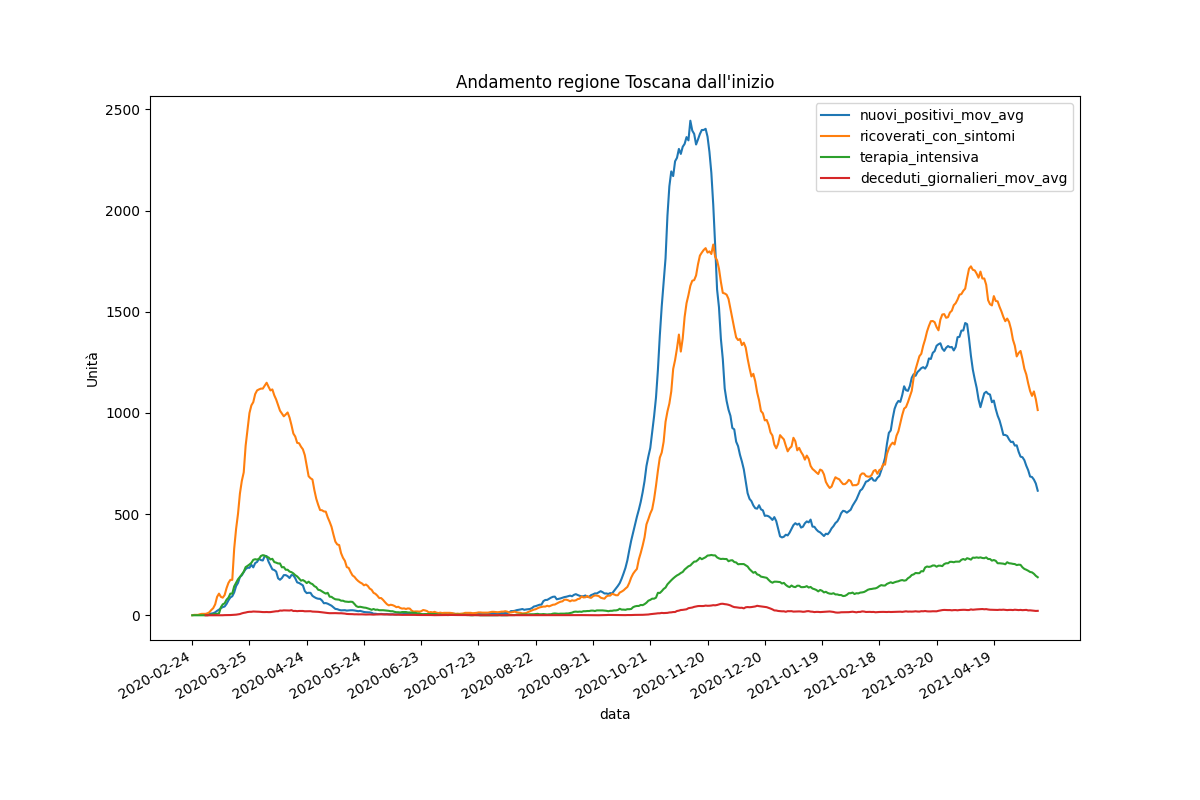

In [12]:
sampling_x = [data for ix, data in enumerate(andamento_regionale["data"]) if ix % 30 == 0]
andamento_regionale.plot(
    x="data",
    xticks=sampling_x,
    y=["nuovi_positivi_mov_avg", "ricoverati_con_sintomi", "terapia_intensiva", "deceduti_giornalieri_mov_avg"],
    title=f"Andamento regione {regione} dall'inizio",
    ylabel="Unità",
    figsize=[12, 8]
);

## Andamento con filtro data

Analisi dati a partire dalla seconda ondata dove si ha maggiore copertura e affidabilità nella raccolta dati

In [13]:
primo_ottobre = "2020-10-01 18:00:00"
inizio_zone_di_colore = "2020-11-06 18:00:00"  # DPCM 3 novembre 2020
filtro_data = primo_ottobre

### Tutte le metriche

<IPython.core.display.Javascript object>


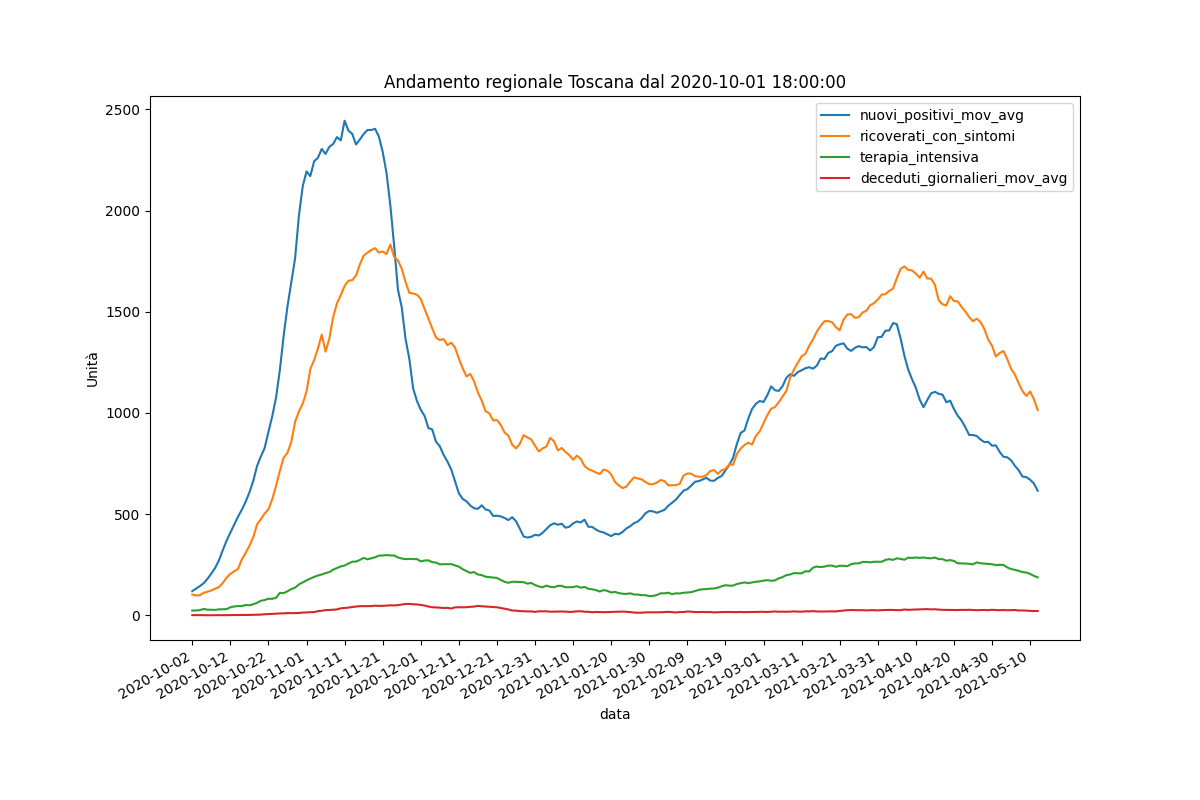

In [14]:
andamento_regionale_filtrato = andamento_regionale[andamento_regionale["data"] >= filtro_data]
sampling_filtrato_x = [data for ix, data in enumerate(andamento_regionale_filtrato["data"]) if ix % 10 == 0]
andamento_regionale_filtrato.plot(
    x="data",
    xticks=sampling_filtrato_x,
    y=["nuovi_positivi_mov_avg", "ricoverati_con_sintomi", "terapia_intensiva", "deceduti_giornalieri_mov_avg"],
    title=f"Andamento regionale {regione} dal {filtro_data}",
    ylabel="Unità",
    figsize=[12, 8]
);

### Nuovi positivi settimanali per centomila abitanti

Limiti utilizzati anche per il cambio colore qui semplificato:
- sotto i 50 per 100 000 a settimana -> OK (limite zona bianca)
- sopra i 250 -> Rosso

In [15]:
inizio_soglia_allerta = 50
limite_soglia_allerta = 250

<IPython.core.display.Javascript object>


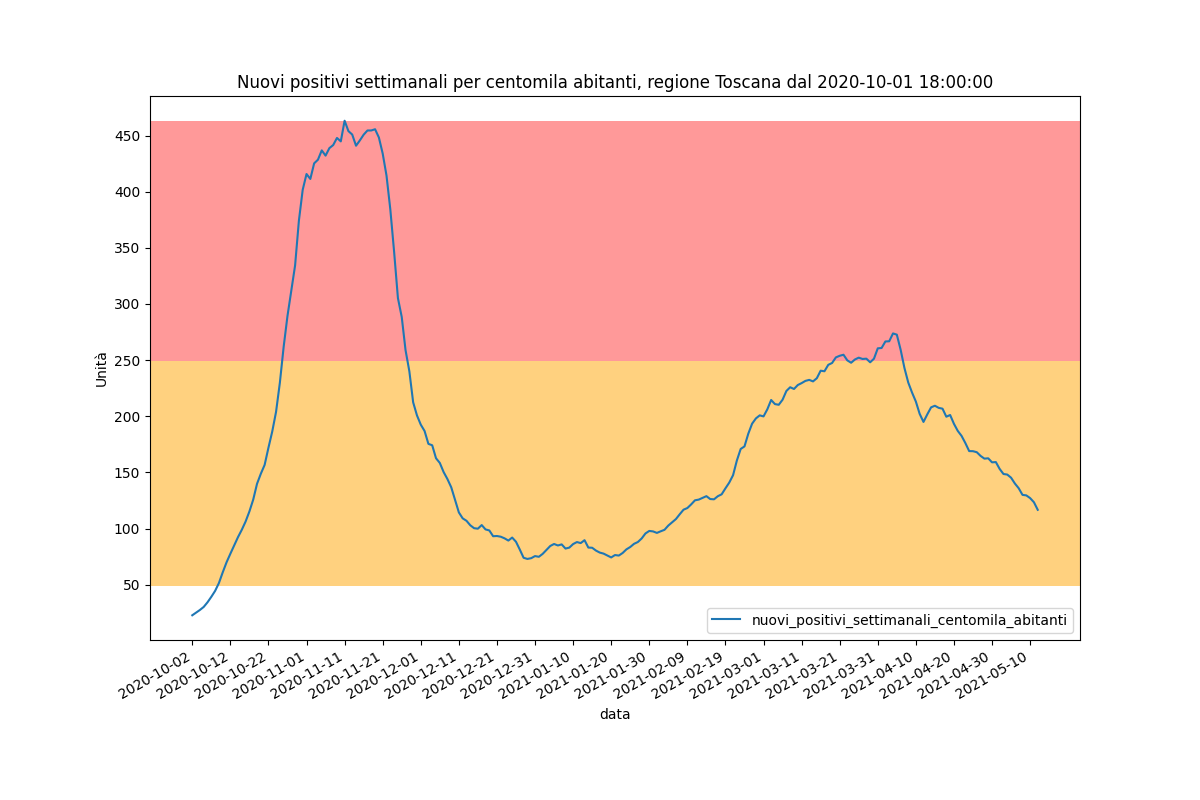

In [16]:
max_y = andamento_regionale_filtrato["nuovi_positivi_settimanali_centomila_abitanti"].max()
sampling_y = range(0, int(max_y), 50)
andamento_regionale_filtrato.plot(
    x="data",
    xticks=sampling_filtrato_x,
    yticks=sampling_y,
    y=["nuovi_positivi_settimanali_centomila_abitanti"],
    title=f"Nuovi positivi settimanali per centomila abitanti, regione {regione} dal {filtro_data}",
    ylabel="Unità",
    figsize=[12, 8]
)
plt.axhspan(inizio_soglia_allerta - 1, min(max_y, limite_soglia_allerta - 1), facecolor='orange', alpha=0.5)
if max_y >= limite_soglia_allerta:
    plt.axhspan(limite_soglia_allerta - 1, max_y, facecolor='r', alpha=0.4)
plt.show()

### Terapia intensiva e decessi

<IPython.core.display.Javascript object>


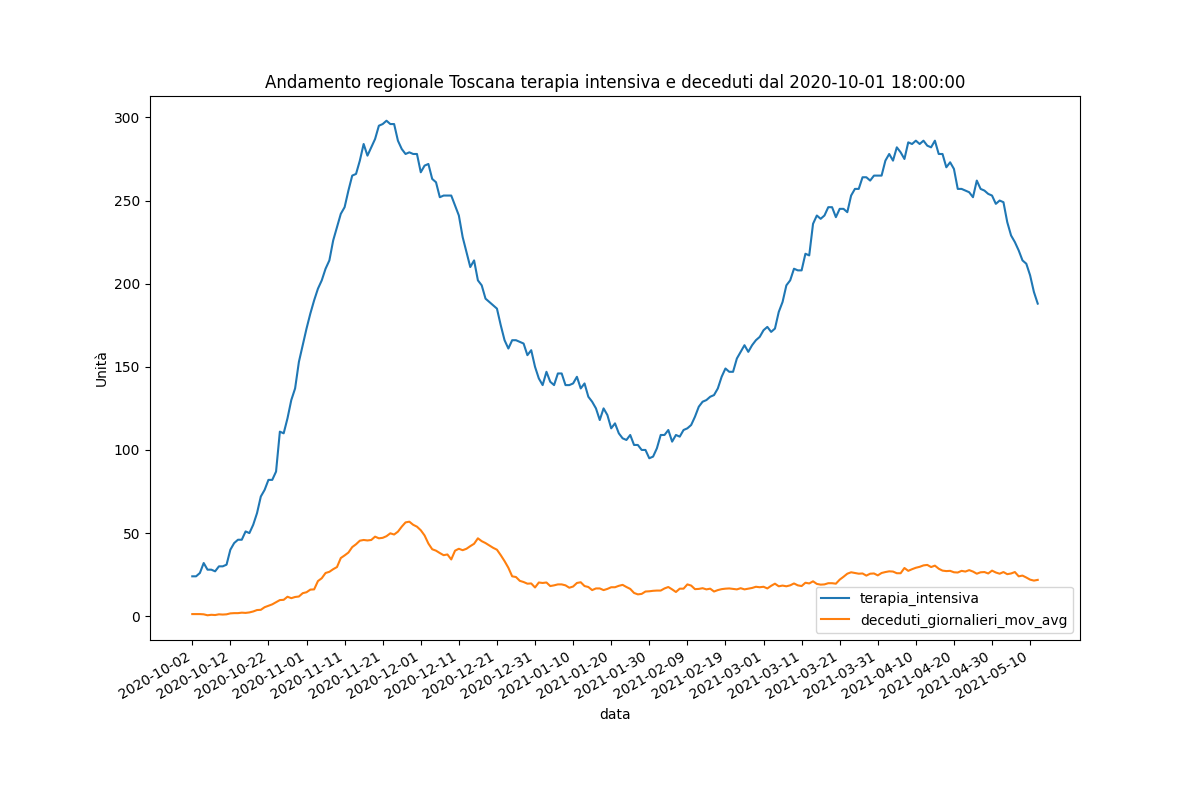

In [17]:
andamento_regionale_filtrato.plot(
    x="data",
    xticks=sampling_filtrato_x,
    y=["terapia_intensiva", "deceduti_giornalieri_mov_avg"],
    title=f"Andamento regionale {regione} terapia intensiva e deceduti dal {filtro_data}",
    ylabel="Unità",
    figsize=[12, 8]
);

### Indice di trasmissibilità Rt

Limiti utilizzati anche per il cambio colore (limite variato nel tempo):
- Tra 1.0 e 1.25 zona arancione
- Sopra 1.25 zona rossa

In [18]:
soglia_rt_arancione = 1.0
soglia_rt_rossa = 1.25

<IPython.core.display.Javascript object>


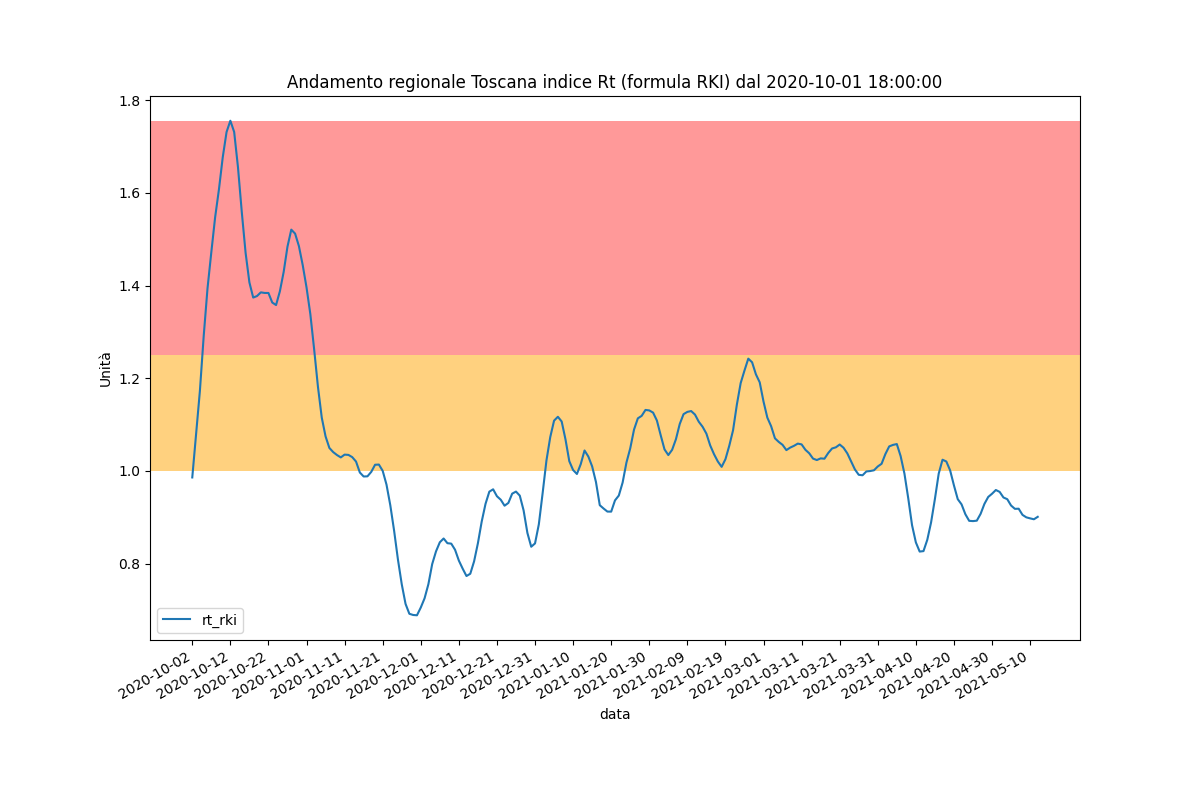

In [19]:
max_y_rt = andamento_regionale_filtrato["rt_rki"].max()
andamento_regionale_filtrato.plot(
    x="data",
    xticks=sampling_filtrato_x,
    y=["rt_rki"],
    title=f"Andamento regionale {regione} indice Rt (formula RKI) dal {filtro_data}",
    ylabel="Unità",
    figsize=[12, 8]
)
plt.axhspan(soglia_rt_arancione,  min(max_y_rt, soglia_rt_rossa), facecolor='orange', alpha=0.5)
if max_y_rt >= soglia_rt_rossa:
    plt.axhspan(soglia_rt_rossa, max_y_rt, facecolor='r', alpha=0.4)
plt.show()

### Normalizzazione

In [20]:
colonne_da_normalizzare = ["nuovi_positivi_mov_avg", "ricoverati_con_sintomi", "terapia_intensiva", "deceduti_giornalieri_mov_avg", "rt_rki"]
for colonna_norm in colonne_da_normalizzare:
    andamento_regionale_filtrato[colonna_norm + "_norm"] = \
        (andamento_regionale_filtrato[colonna_norm] - andamento_regionale_filtrato[colonna_norm].min()) / \
        (andamento_regionale_filtrato[colonna_norm].max() - andamento_regionale_filtrato[colonna_norm].min())

/home/michele/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


<IPython.core.display.Javascript object>


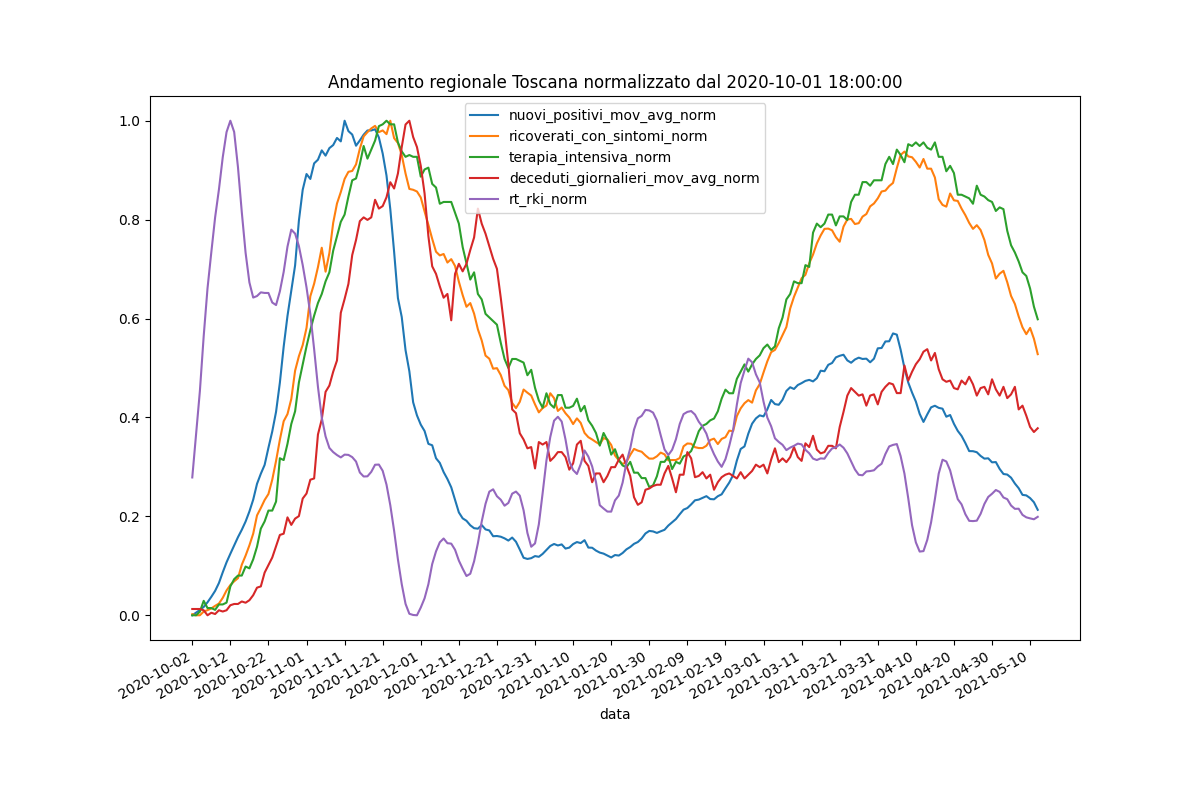

In [21]:
andamento_regionale_filtrato.plot(
    x="data",
    xticks=sampling_filtrato_x,
    y=["nuovi_positivi_mov_avg_norm", "ricoverati_con_sintomi_norm", "terapia_intensiva_norm", "deceduti_giornalieri_mov_avg_norm", "rt_rki_norm"],
    title=f"Andamento regionale {regione} normalizzato dal {filtro_data}",
    figsize=[12, 8]
);

# Zone di colore

In [22]:
f"Inizio applicazione zone di colore {inizio_zone_di_colore}"

'Inizio applicazione zone di colore 2020-11-06 18:00:00'

Zone nazionali e semplificazioni:
- Periodo dal 24 al 6 gennaio tutto zona rossa, anche se in mezzo ci sono state altre colorazioni
- Non considerate zone provinciali differenti, solo zona regionale
- Uno stesso colore in periodi diversi può avere regole differenti

In [23]:
inizio_primo_periodo = "06/11/2020"
fine_max_primo_periodo = "20/11/2020"
inizio_periodo_natale = "24/12/2020"
fine_periodo_natale = "06/01/2021"
inizio_decreto_pasqua = "15/03/2021"
fine_decreto_pasqua = "06/04/2021" # Questo giorno sarà in realtà ignorato con la logica attuale
inizio_periodo_pasqua = "03/04/2021"
fine_periodo_pasqua = "05/04/2021"

Recupero quadro normativo fonte prociv

In [24]:
aree_json_file = os.path.join(prociv_repo_dir, "aree/geojson/dpc-covid-19-aree-nuove-g.json")
with open(aree_json_file) as input_fp:
    aree_json = json.load(input_fp)

Recupero zone del primo periodo aggiunte manualmente https://www.altalex.com/documents/leggi/2020/11/04/nuovo-dpcm-dal-5-novembre-italia-divisa-in-tre-zone

In [25]:
zone_primo_periodo = pd.read_csv(os.path.join("dati_aggiuntivi", "zone_di_colore_prima_settimana.csv"), index_col=False, dtype="string")
colore_primo_periodo = zone_primo_periodo[zone_primo_periodo["Zona"] == regione]["Colore"].values[0]

Recupero zone dal file prodotto dalla prociv

In [26]:
zone = list()
for area in aree_json["features"]:
    properties = area["properties"]
    if properties["nomeTesto"] == regione and properties["legLivello"] == "regionale":
        # print(properties)
        colore = get_colore(properties['legSpecRif'].strip())
        new_zona = {"inizio": properties['datasetIni'], "fine": properties['datasetFin'], "colore": colore}
        print(f"{new_zona}, articolo: {properties['legSpecRif']}")
        zone.append(new_zona)

{'inizio': '10/11/2020', 'fine': '24/11/2020', 'colore': 'orange'}, articolo: art.2
{'inizio': '15/11/2020', 'fine': '29/11/2020', 'colore': 'red'}, articolo: art.3
{'inizio': '15/11/2020', 'fine': '03/12/2020', 'colore': 'red'}, articolo: art.3
{'inizio': '06/12/2020', 'fine': '20/12/2020', 'colore': 'orange'}, articolo: art.2
{'inizio': '06/12/2020', 'fine': '20/12/2020', 'colore': 'yellow'}, articolo: art.1
{'inizio': '10/01/2021', 'fine': '15/01/2021', 'colore': 'yellow'}, articolo: art.1
{'inizio': '16/01/2021', 'fine': '05/03/2021', 'colore': 'yellow'}, articolo: art.1
{'inizio': '14/02/2021', 'fine': '28/02/2021', 'colore': 'orange'}, articolo: art.2
{'inizio': '01/03/2021', 'fine': '15/03/2021', 'colore': 'orange'}, articolo: art.2
{'inizio': '29/03/2021', 'fine': '06/04/2021', 'colore': 'red'}, articolo: art.3
{'inizio': '06/04/2021', 'fine': '20/04/2021', 'colore': 'red'}, articolo: art.3
{'inizio': '12/04/2021', 'fine': '30/04/2021', 'colore': 'orange'}, articolo: art.2
{'in

Analisi doppie assegnazioni ad uno stesso periodo

In [27]:
inizio_fine = list()
for zona in zone:
    inizio = zona["inizio"]
    fine = zona["fine"]
    if (inizio, fine) in inizio_fine:
        print(f"Periodo dal {inizio} al {fine} inserito più volte: indagare")
    inizio_fine.append((inizio, fine))

Periodo dal 06/12/2020 al 20/12/2020 inserito più volte: indagare


Correzioni:
- Ci sono delle sovrapposizioni nelle zone di colore delle sovrapposizioni da indagare
  - Errore Toscana: Inizio 06/12/2020 sia art.1 e art.2 con fine stimata 20/12/2020. In realtà è solo articolo 2 (arancione). https://www.trovanorme.salute.gov.it/norme/dettaglioAtto?id=77516
  - Non testato con altre regioni, ma è probabile che accada con Campania, P.A. Bolzano e Valle d'Aosta nel solito periodo, vedi link sopra
- Manca la prima zona di colore decisa dal 6 novembre e valida massimo fino al 20. Aggiunto un CSV manualmente.
- Mancano i dati dal 15 marzo al 6 aprile, decreto Pasqua specifico da lunedì 15 marzo al 6 aprile 2021. A parte la Sardegna bianca, le altre passano tutte ad arancione.
- Alcune fasce nel weekend sono scoperte. si prende l'ultimo colore disponibile

In [28]:
zone_corrette = OrderedDict()
for zona in zone:
    if regione == "Toscana" and zona["inizio"] == "06/12/2020" and zona["fine"] == "20/12/2020" and zona["colore"] == "yellow":
        continue
    date_inizio = datetime.strptime(zona["inizio"], '%d/%m/%Y')
    if zona["fine"].strip() == "":
        # Fine non settata, si prende la data maggiore
        date_fine = andamento_regioni['data'].max()
    else:
        date_fine = datetime.strptime(zona["fine"], '%d/%m/%Y')
    zone_corrette[date_inizio] = {"inizio": date_inizio, "fine": date_fine, "colore": zona["colore"]}

# Primo periodo
zone_corrette[datetime.strptime(inizio_primo_periodo, '%d/%m/%Y')] = {
    "inizio": datetime.strptime(inizio_primo_periodo, '%d/%m/%Y'),
    "fine": datetime.strptime(fine_max_primo_periodo, '%d/%m/%Y'),
    "colore": colore_primo_periodo
}
    
# Festività
zone_corrette[datetime.strptime(inizio_periodo_natale, '%d/%m/%Y')] = {
    "inizio": datetime.strptime(inizio_periodo_natale, '%d/%m/%Y'),
    "fine": datetime.strptime(fine_periodo_natale, '%d/%m/%Y'),
    "colore": "red"
}
zone_corrette[datetime.strptime(inizio_decreto_pasqua, '%d/%m/%Y')] = {
    "inizio": datetime.strptime(inizio_decreto_pasqua, '%d/%m/%Y'),
    "fine": datetime.strptime(fine_decreto_pasqua, '%d/%m/%Y'),
    "colore": "white" if regione == "Sardegna" else "orange"
}
zone_corrette[datetime.strptime(inizio_periodo_pasqua, '%d/%m/%Y')] = {
    "inizio": datetime.strptime(inizio_periodo_pasqua, '%d/%m/%Y'),
    "fine": datetime.strptime(fine_periodo_pasqua, '%d/%m/%Y'),
    "colore": "red"
}

# Eliminazione sovrapprosizioni e riempimento aree vuote prolungando il colore (tipicamente weekend)
last_inizio = None
for key, zona in sorted(zone_corrette.items(), key = lambda x:x, reverse=True):
    if last_inizio is not None:
        zona["fine"] = last_inizio - timedelta(days=1)
    last_inizio = zona["inizio"]
    
for key, zona in sorted(zone_corrette.items(), key = lambda x:x):
    print(zona)

{'inizio': datetime.datetime(2020, 11, 6, 0, 0), 'fine': datetime.datetime(2020, 11, 9, 0, 0), 'colore': 'yellow'}
{'inizio': datetime.datetime(2020, 11, 10, 0, 0), 'fine': datetime.datetime(2020, 11, 14, 0, 0), 'colore': 'orange'}
{'inizio': datetime.datetime(2020, 11, 15, 0, 0), 'fine': datetime.datetime(2020, 12, 5, 0, 0), 'colore': 'red'}
{'inizio': datetime.datetime(2020, 12, 6, 0, 0), 'fine': datetime.datetime(2020, 12, 23, 0, 0), 'colore': 'orange'}
{'inizio': datetime.datetime(2020, 12, 24, 0, 0), 'fine': datetime.datetime(2021, 1, 9, 0, 0), 'colore': 'red'}
{'inizio': datetime.datetime(2021, 1, 10, 0, 0), 'fine': datetime.datetime(2021, 1, 15, 0, 0), 'colore': 'yellow'}
{'inizio': datetime.datetime(2021, 1, 16, 0, 0), 'fine': datetime.datetime(2021, 2, 13, 0, 0), 'colore': 'yellow'}
{'inizio': datetime.datetime(2021, 2, 14, 0, 0), 'fine': datetime.datetime(2021, 2, 28, 0, 0), 'colore': 'orange'}
{'inizio': datetime.datetime(2021, 3, 1, 0, 0), 'fine': datetime.datetime(2021, 3,

## Andamento nuovi positivi e zone di colore

<IPython.core.display.Javascript object>


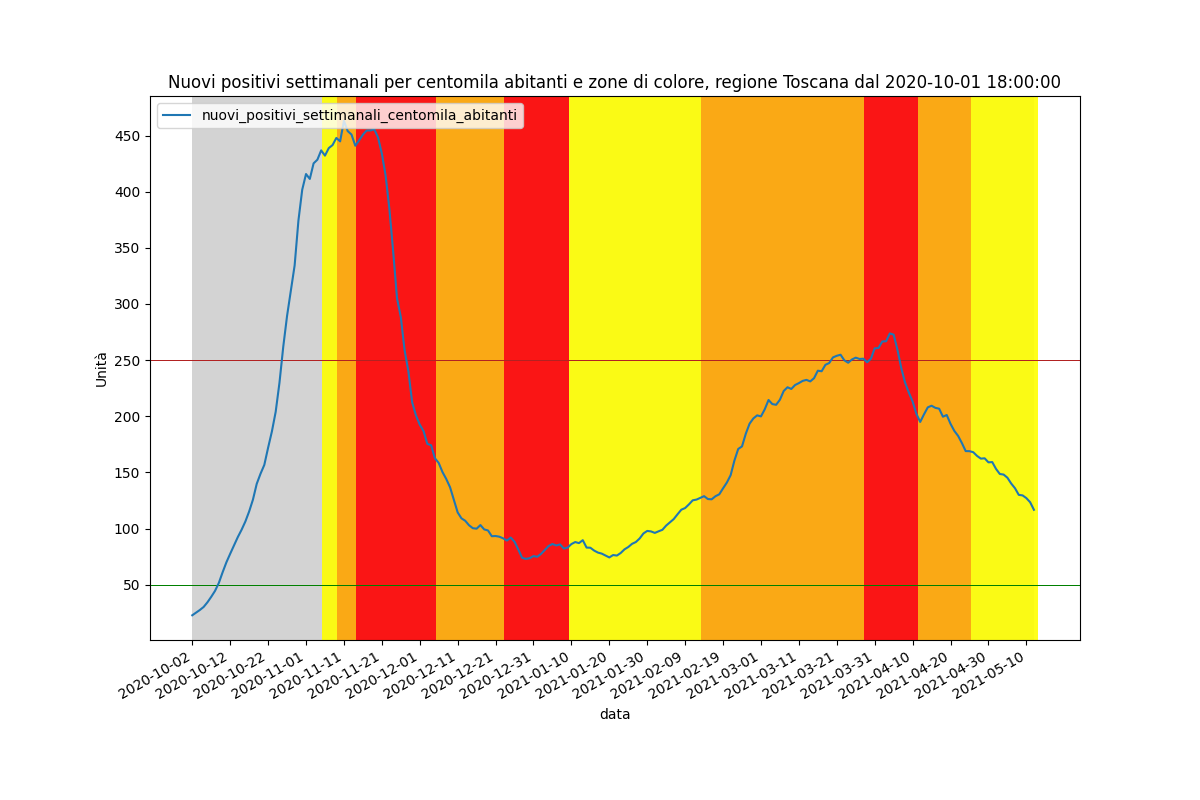

In [29]:
andamento_regionale_filtrato_zone = andamento_regionale[andamento_regionale["data"] >= primo_ottobre]
max_y = andamento_regionale_filtrato_zone["nuovi_positivi_settimanali_centomila_abitanti"].max()
sampling_y = range(0, int(max_y), 50)
andamento_regionale_filtrato_zone.plot(
    x="data",
    xticks=sampling_filtrato_x,
    yticks=sampling_y,
    y=["nuovi_positivi_settimanali_centomila_abitanti"],
    title=f"Nuovi positivi settimanali per centomila abitanti e zone di colore, regione {regione} dal {filtro_data}",
    ylabel="Unità",
    figsize=[12, 8]
)
# Sfondo grigio
plt.axvspan(andamento_regionale_filtrato_zone["data"].min(), andamento_regionale_filtrato_zone["data"].max(), facecolor='lightgrey', alpha=1.0)
# Cambi di colore
for key, zona in sorted(zone_corrette.items(), key = lambda x:x):
    plt.axvspan(zona["inizio"], zona["fine"] + timedelta(days=1), facecolor=zona["colore"], alpha=0.9)
# Linee soglia
plt.axhspan(inizio_soglia_allerta - 1, inizio_soglia_allerta, facecolor='green', alpha=1.0)
if max_y >= limite_soglia_allerta:
    plt.axhspan(limite_soglia_allerta - 1, limite_soglia_allerta, facecolor='firebrick', alpha=1.0)
plt.show()

## Variazioni giornaliere nuovi positivi e zone di colore

/home/michele/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


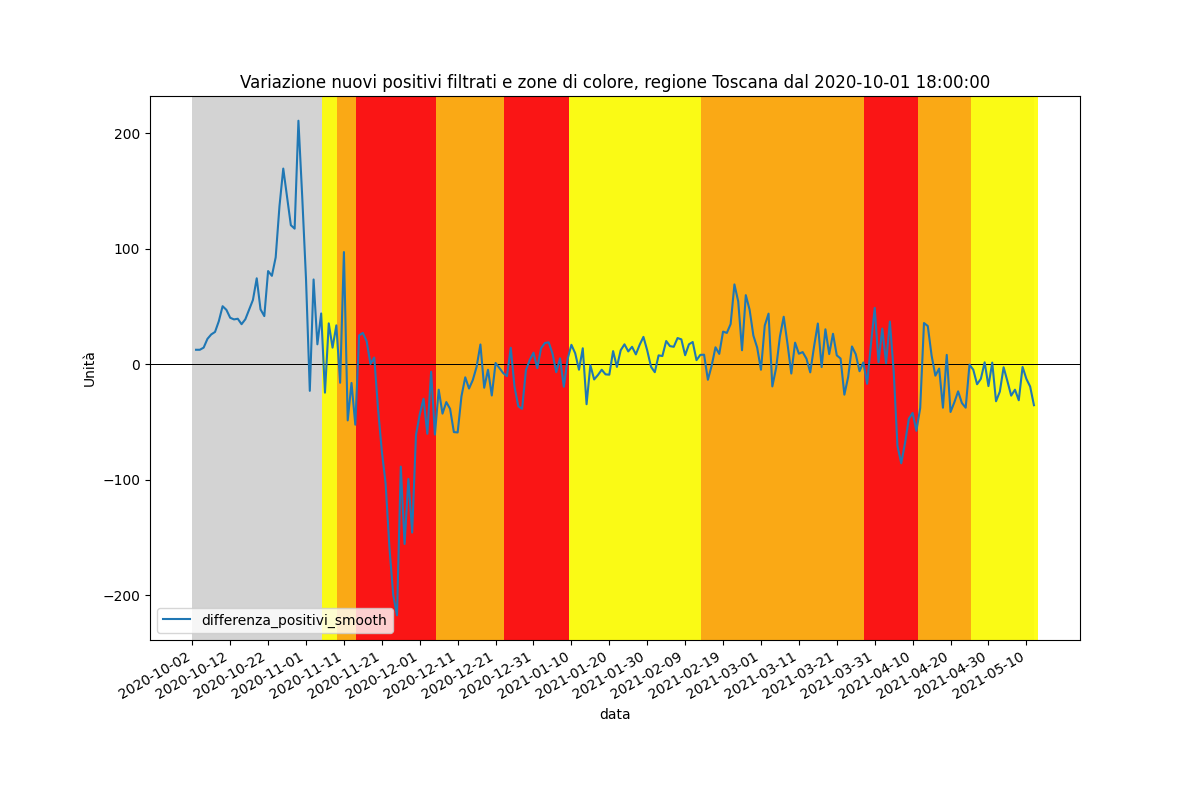

In [32]:
andamento_regionale_filtrato_zone['differenza_positivi_smooth'] = andamento_regionale_filtrato_zone.nuovi_positivi_mov_avg.diff()
andamento_regionale_filtrato_zone.plot(
    x="data",
    xticks=sampling_filtrato_x,
    y=["differenza_positivi_smooth"],
    title=f"Variazione nuovi positivi filtrati e zone di colore, regione {regione} dal {filtro_data}",
    ylabel="Unità",
    figsize=[12, 8]
)
# Sfondo grigio
plt.axvspan(andamento_regionale_filtrato_zone["data"].min(), andamento_regionale_filtrato_zone["data"].max(), facecolor='lightgrey', alpha=1.0)
# Cambi di colore
for key, zona in sorted(zone_corrette.items(), key = lambda x:x):
    plt.axvspan(zona["inizio"], zona["fine"] + timedelta(days=1), facecolor=zona["colore"], alpha=0.9)
# Linee zero
plt.axhspan(-1, 0, facecolor='black', alpha=1.0)
plt.show()

## Andamento indice di trasmissibilità Rt e zone di colore

<IPython.core.display.Javascript object>


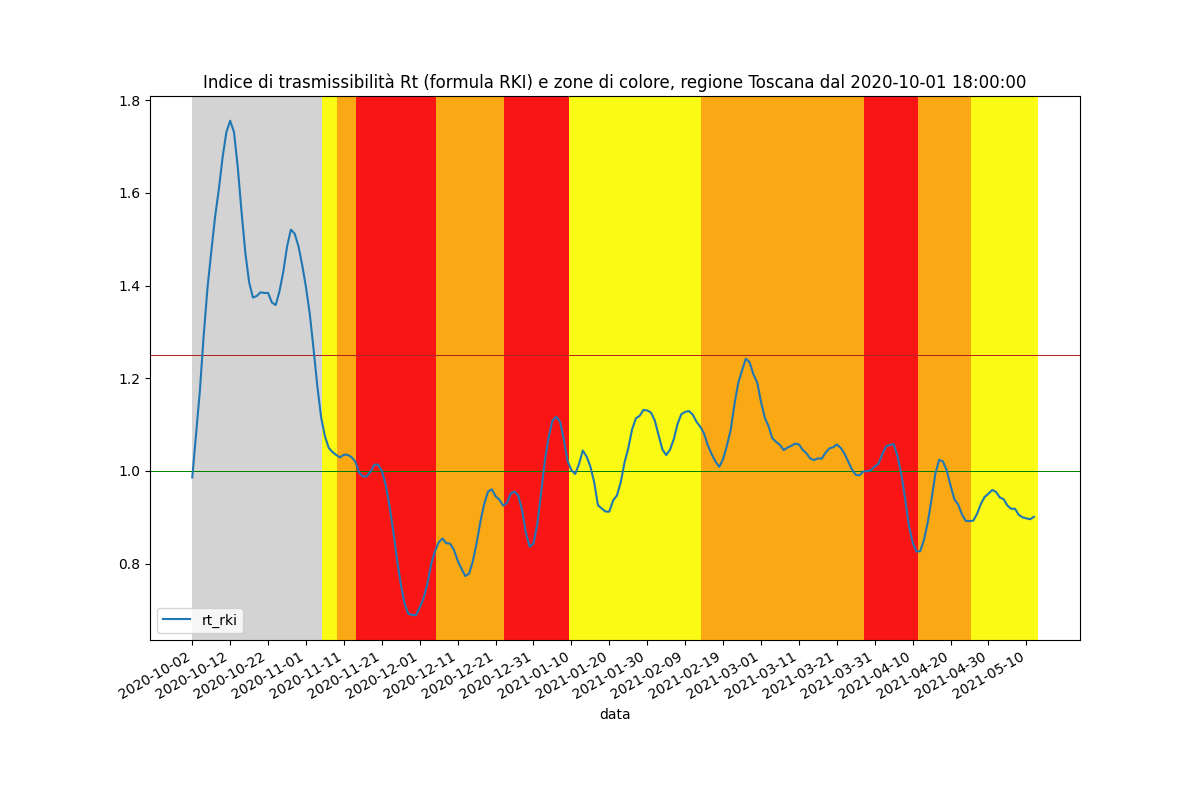

In [31]:
andamento_regionale_filtrato_zone = andamento_regionale[andamento_regionale["data"] >= primo_ottobre]
max_y_rt = andamento_regionale_filtrato_zone["rt_rki"].max()
andamento_regionale_filtrato_zone.plot(
    x="data",
    xticks=sampling_filtrato_x,
    y=["rt_rki"],
    title=f"Indice di trasmissibilità Rt (formula RKI) e zone di colore, regione {regione} dal {filtro_data}",
    figsize=[12, 8]
)
# Sfondo grigio
plt.axvspan(andamento_regionale_filtrato_zone["data"].min(), andamento_regionale_filtrato_zone["data"].max(), facecolor='lightgrey', alpha=1.0)
# Cambi di colore
for key, zona in sorted(zone_corrette.items(), key = lambda x:x):
    plt.axvspan(zona["inizio"], zona["fine"] + timedelta(days=1), facecolor=zona["colore"], alpha=0.9)
# Linee soglia
plt.axhspan(soglia_rt_arancione - 0.002, soglia_rt_arancione, facecolor='green', alpha=1.0)
if max_y >= soglia_rt_rossa:
    plt.axhspan(soglia_rt_rossa - 0.002, soglia_rt_rossa, facecolor='firebrick', alpha=1.0)
plt.show()